
# Task Submission: Predict Daily Global Deaths

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# 1. Import Libraries and input data

In [2]:
#import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import requests
import numpy as np
import pandas as pd
import io

BASE_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = 'time_series_covid19_confirmed_global.csv'
DEATH = 'time_series_covid19_deaths_global.csv'
RECOVERED = 'time_series_covid19_recovered_global.csv'
CONFIRMED_US = 'time_series_covid19_confirmed_US.csv'
DEATH_US = 'time_series_covid19_deaths_US.csv'

def get_covid_data(subset = 'CONFIRMED'):
    """This function returns the latest available data subset of COVID-19. 
        The returned value is in pandas DataFrame type.
    Args:
        subset (:obj:`str`, optional): Any value out of 5 subsets of 'CONFIRMED',
        'DEATH', 'RECOVERED', 'CONFIRMED_US' and 'DEATH_US' is a valid input. If the value
        is not chosen or typed wrongly, CONFIRMED subet will be returned.
    """    

    if subset.upper() == 'DEATH':
        CSV_URL = BASE_URL + DEATH
    elif subset.upper() == 'RECOVERED':
        CSV_URL = BASE_URL + RECOVERED        
    elif subset.upper() == 'CONFIRMED_US':
        CSV_URL = BASE_URL + CONFIRMED_US        
    elif subset.upper() == 'DEATH_US':
        CSV_URL = BASE_URL + DEATH_US        
    else:
        CSV_URL = BASE_URL + CONFIRMED

    with requests.Session() as s:
        download = s.get(CSV_URL)
        decoded_content = download.content.decode('utf-8')
        data = pd.read_csv(io.StringIO(decoded_content))

    return data

In [4]:
df_train_confirmed = get_covid_data(subset = 'DEATH')
df_train_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,18,21,23,25,30,30,30,33,36,36
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,23,23,24,25,26,26,26,26,26,26
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,293,313,326,336,348,364,367,375,384,392
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,29,29,31,33,33,35,35,36,37,37
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [5]:
# We will fill the missing states with a value 'NoState'
df_train_confirmed=df_train_confirmed.fillna('NoState')
# changing the data type
df_train_confirmed.head()
#train=train.rename(columns={ConfirmedCases:'Confirmed','Country_Region':'Country/Region',
                    # 'Province_State':'Province/State','Date':'ObservationDate'})
#num_cols=['Confirmed']
#for col in num_cols:
#    temp=[int(i) for i in train[col]]
#    train[col]=temp 
#train.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NoState,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,18,21,23,25,30,30,30,33,36,36
1,NoState,Albania,41.1533,20.1683,0,0,0,0,0,0,...,23,23,24,25,26,26,26,26,26,26
2,NoState,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,293,313,326,336,348,364,367,375,384,392
3,NoState,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,29,29,31,33,33,35,35,36,37,37
4,NoState,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [6]:
#countries=['India','Italy','Spain']

#y=df_train_confirmed.loc[df_train_confirmed['Country/Region']=='Brazil'].iloc[0,4:]
#s = pd.DataFrame({'Brazil':y})
#for c in countries:    
    #pyplot.plot(range(y.shape[0]),y,'r--')
#    s[c] = df_train_confirmed.loc[df_train_confirmed['Country/Region']==c].iloc[0,4:]
#pyplot.plot(range(y.shape[0]),y,'g-')
#plt.plot(range(y.shape[0]), s)
#plt.legend(countries)

#s.tail(5)



# 2. Prediction using Prophet

In [7]:
df_usa1 = df_train_confirmed.loc[df_train_confirmed["Country/Region"]== "US"]
df_spain=df_train_confirmed.loc[df_train_confirmed["Country/Region"]== "Spain"]
df_india=df_train_confirmed.loc[df_train_confirmed["Country/Region"]== "India"]
df_brazil=df_train_confirmed.loc[df_train_confirmed["Country/Region"]== "Brazil"]

In [8]:
dates1=df_train_confirmed[4:]
temp_usa = df_usa1.melt(value_vars=dates1, var_name='Date', value_name='Confirmed')
temp_usa = temp_usa.groupby('Date')['Confirmed'].sum().reset_index()

pr_usa = pd.DataFrame(temp_usa)

pr_usa.columns = ['ds','y']
pr_usa.drop(pr_usa.tail(4).index,inplace=True)

#Spain
temp_spain = df_spain.melt(value_vars=dates1, var_name='Date', value_name='Confirmed')
temp_spain = temp_spain.groupby('Date')['Confirmed'].sum().reset_index()

pr_spain = pd.DataFrame(temp_spain)

pr_spain.columns = ['ds','y']
pr_spain.drop(pr_spain.tail(4).index,inplace=True)

#India
temp_india = df_india.melt(value_vars=dates1, var_name='Date', value_name='Confirmed')
temp_india = temp_india.groupby('Date')['Confirmed'].sum().reset_index()

pr_india = pd.DataFrame(temp_india)

pr_india.columns = ['ds','y']
pr_india.drop(pr_india.tail(4).index,inplace=True)

#Brazil
temp_brazil = df_brazil.melt(value_vars=dates1, var_name='Date', value_name='Confirmed')
temp_brazil = temp_brazil.groupby('Date')['Confirmed'].sum().reset_index()

pr_brazil = pd.DataFrame(temp_brazil)

pr_brazil.columns = ['ds','y']
pr_brazil.drop(pr_brazil.tail(4).index,inplace=True)


In [9]:
import fbprophet
#USA
m=fbprophet.Prophet()
m.fit(pr_usa)
future=m.make_future_dataframe(periods=10)
forecast_usa=m.predict(future)
forecast_usa.tail(11)

#Spain
m=fbprophet.Prophet()
m.fit(pr_spain)
future=m.make_future_dataframe(periods=10)
forecast_spain=m.predict(future)
forecast_spain.tail(11)

#India

m=fbprophet.Prophet()
m.fit(pr_india)
future=m.make_future_dataframe(periods=10)
forecast_india=m.predict(future)
forecast_india.tail(11)

#Brazil
m=fbprophet.Prophet()
m.fit(pr_brazil)
future=m.make_future_dataframe(periods=10)
forecast_brazil=m.predict(future)
forecast_brazil.tail(11)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
90,2020-04-21,2553.841401,2476.197488,2634.387550,2553.841401,2553.841401,0.915238,0.915238,0.915238,0.915238,0.915238,0.915238,0.0,0.0,0.0,2554.756639
91,2020-04-22,2680.327228,2595.514409,2753.914661,2679.915313,2680.497238,-4.207853,-4.207853,-4.207853,-4.207853,-4.207853,-4.207853,0.0,0.0,0.0,2676.119374
92,2020-04-23,2806.813054,2735.158857,2889.911958,2802.540873,2810.379010,7.226386,7.226386,7.226386,7.226386,7.226386,7.226386,0.0,0.0,0.0,2814.039440
93,2020-04-24,2933.298880,2860.062145,3020.144115,2924.620310,2942.558969,5.489735,5.489735,5.489735,5.489735,5.489735,5.489735,0.0,0.0,0.0,2938.788615
94,2020-04-25,3059.784706,2985.056401,3144.845807,3044.667241,3076.255253,4.521105,4.521105,4.521105,4.521105,4.521105,4.521105,0.0,0.0,0.0,3064.305811
95,2020-04-26,3186.270533,3094.251829,3262.216581,3166.123114,3210.999519,-4.601975,-4.601975,-4.601975,-4.601975,-4.601975,-4.601975,0.0,0.0,0.0,3181.668557
96,2020-04-27,3312.756359,3211.184691,3395.547036,3284.457656,3346.787397,-9.342635,-9.342635,-9.342635,-9.342635,-9.342635,-9.342635,0.0,0.0,0.0,3303.413724
97,2020-04-28,3439.242185,3352.526129,3537.600233,3401.606437,3483.449535,0.915238,0.915238,0.915238,0.915238,0.915238,0.915238,0.0,0.0,0.0,3440.157423
98,2020-04-29,3565.728011,3469.880711,3668.766285,3519.992597,3620.864520,-4.207853,-4.207853,-4.207853,-4.207853,-4.207853,-4.207853,0.0,0.0,0.0,3561.520158
99,2020-04-30,3692.213838,3598.219192,3803.172005,3636.096684,3760.587396,7.226386,7.226386,7.226386,7.226386,7.226386,7.226386,0.0,0.0,0.0,3699.440224


In [10]:
cnfrm = forecast_usa.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Death_prophet_usa']
prophet_data_usa=cnfrm.tail(10)
prophet_data_usa
#Spain
cnfrm = forecast_spain.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Death_prophet_spain']
prophet_data_spain=cnfrm.tail(10)
prophet_data_spain
#India
cnfrm = forecast_india.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Death_prophet_india']
prophet_data_india=cnfrm.tail(10)
prophet_data_india
#Brazil
cnfrm = forecast_brazil.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Death_prophet_brazil']
prophet_data_brazil=cnfrm.tail(10)
prophet_data_brazil


,Date,Death_prophet_brazil
91,2020-04-22,2680.327228
92,2020-04-23,2806.813054
93,2020-04-24,2933.298880
94,2020-04-25,3059.784706
95,2020-04-26,3186.270533
96,2020-04-27,3312.756359
97,2020-04-28,3439.242185
98,2020-04-29,3565.728011
99,2020-04-30,3692.213838
100,2020-05-01,3818.699664


# 3. Predictions using LSTM

In [11]:
df_usa1 = df_usa1.iloc[:, 5:]
df_spain= df_spain.iloc[:,5:]
df_india = df_india.iloc[:, 5:]
df_brazil= df_brazil.iloc[:,5:]


In [12]:
#Predicting future deaths of USA using LSTM network
daily_cases = df_usa1.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()
#we take 20% of total data for validation and rest for testing i.e;(as of now 80 days first 64 days for testing and 16 days for validation)
test_data_size = 16

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape
#Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

#Create a sequence
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

import torch
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

import torch.nn as nn
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 500   # if its time consuming then set it to 500 or 100
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

#Training the model
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    
true_cases_usa = scaler.inverse_transform(
np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases_usa = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Epoch 0 train loss: 2.970505952835083 test loss: 115.10980987548828
Epoch 100 train loss: 0.5279650092124939 test loss: 389.68096923828125
Epoch 200 train loss: 0.5222137570381165 test loss: 398.7669982910156
Epoch 300 train loss: 0.49233952164649963 test loss: 361.7932434082031
Epoch 400 train loss: 0.5138014554977417 test loss: 311.60870361328125


In [13]:
#Predicting deaths of spain using LSTM network
daily_cases = df_spain.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()
#we take 20% of total data for validation and rest for testing i.e;(as of now 80 days first 64 days for testing and 16 days for validation)
test_data_size = 16

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape
#Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

#Create a sequence
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

import torch
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

import torch.nn as nn
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 500   # if its time consuming then set it to 500 or 100
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

#Training the model
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    
true_cases_spain = scaler.inverse_transform(
np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_deaths_spain = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Epoch 0 train loss: 5.148521423339844 test loss: 23.245784759521484
Epoch 100 train loss: 1.0730684995651245 test loss: 432.7715759277344
Epoch 200 train loss: 0.8420141935348511 test loss: 193.98486328125
Epoch 300 train loss: 0.8419845700263977 test loss: 229.09039306640625
Epoch 400 train loss: 0.806984543800354 test loss: 84.04515075683594


In [14]:
#Predicting deaths of India using LSTM network
daily_cases = df_india.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()
#we take 20% of total data for validation and rest for testing i.e;(as of now 80 days first 64 days for testing and 16 days for validation)
test_data_size = 16

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape
#Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

#Create a sequence
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

import torch
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

import torch.nn as nn
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 500   # if its time consuming then set it to 500 or 100
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

#Training the model
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    
true_cases_india = scaler.inverse_transform(
np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_deaths_india = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Epoch 0 train loss: 2.270458936691284 test loss: 199.05975341796875
Epoch 100 train loss: 0.6414142847061157 test loss: 247.20411682128906
Epoch 200 train loss: 0.5680385231971741 test loss: 199.9933624267578
Epoch 300 train loss: 0.5737749338150024 test loss: 144.5257110595703
Epoch 400 train loss: 0.6267350912094116 test loss: 76.6837158203125


In [15]:
#Predicting deaths of Brazil using LSTM network
daily_cases = df_brazil.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()
#we take 20% of total data for validation and rest for testing i.e;(as of now 80 days first 64 days for testing and 16 days for validation)
test_data_size = 16

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape
#Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

#Create a sequence
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

import torch
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

import torch.nn as nn
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 500   # if its time consuming then set it to 500 or 100
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

#Training the model
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    
true_cases_brazil = scaler.inverse_transform(
np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_deaths_brazil = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Epoch 0 train loss: 2.686311721801758 test loss: 154.679931640625
Epoch 100 train loss: 0.6275964975357056 test loss: 132.95245361328125
Epoch 200 train loss: 0.5298914909362793 test loss: 183.66551208496094
Epoch 300 train loss: 0.5625221133232117 test loss: 196.77523803710938
Epoch 400 train loss: 0.5141209959983826 test loss: 231.5487060546875


In [16]:
prophet_data_usa.insert(2,'LSTM_usa',predicted_cases_usa)
prophet_data_spain.insert(2,'LSTM_spain',predicted_deaths_spain)
prophet_data_india.insert(2,'LSTM_india',predicted_deaths_india)
prophet_data_brazil.insert(2,'LSTM_brazil',predicted_deaths_brazil)

In [17]:
USA_data=pd.DataFrame(prophet_data_usa)
USA_data['FutureDates']=USA_data['Date'].apply(lambda x: x.strftime('%d%m%Y'))

Spain_data=pd.DataFrame(prophet_data_spain)
Spain_data['FutureDates']=Spain_data['Date'].apply(lambda x: x.strftime('%d%m%Y'))

India_data=pd.DataFrame(prophet_data_india)
India_data['FutureDates']=India_data['Date'].apply(lambda x: x.strftime('%d%m%Y'))

Brazil_data=pd.DataFrame(prophet_data_brazil)
Brazil_data['FutureDates']=Brazil_data['Date'].apply(lambda x: x.strftime('%d%m%Y'))

# 4 . Plotting future predicted data

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. U

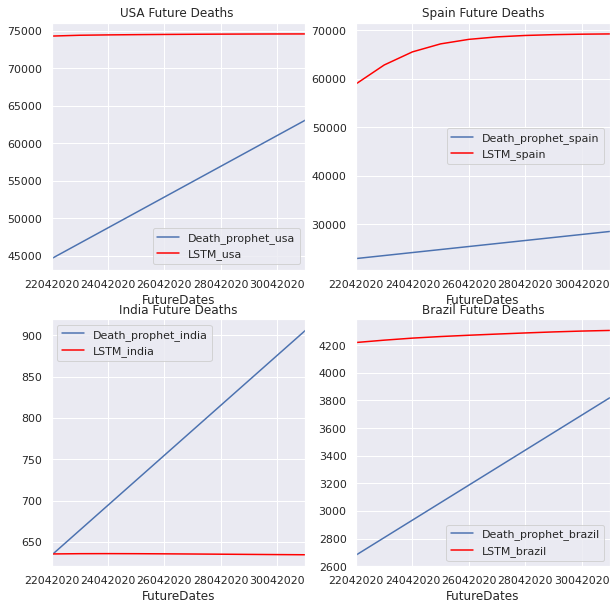

In [18]:

fig, axes = plt.subplots(nrows=2, ncols=2)

USA_data.plot(kind='line',x='FutureDates',y='Death_prophet_usa',ax=axes[0,0],figsize=(10,10))
USA_data.plot(kind='line',x= 'FutureDates',y='LSTM_usa', color='red', ax=axes[0,0])
axes[0, 0].set_title('USA Future Deaths ')

Spain_data.plot(kind='line',x='FutureDates',y='Death_prophet_spain',ax=axes[0,1],figsize=(10,10))
Spain_data.plot(kind='line',x= 'FutureDates',y='LSTM_spain', color='red', ax=axes[0,1])
axes[0, 1].set_title('Spain Future Deaths')

India_data.plot(kind='line',x='FutureDates',y='Death_prophet_india',ax=axes[1,0],figsize=(10,10))
India_data.plot(kind='line',x= 'FutureDates',y='LSTM_india', color='red', ax=axes[1,0])
axes[1, 0].set_title('India Future Deaths')

Brazil_data.plot(kind='line',x='FutureDates',y='Death_prophet_brazil',ax=axes[1,1],figsize=(10,10))
Brazil_data.plot(kind='line',x= 'FutureDates',y='LSTM_brazil', color='red', ax=axes[1,1])
axes[1, 1].set_title('Brazil Future Deaths')

plt.show()